In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.linalg
import matplotlib.pyplot as plt
import sklearn.metrics
import sklearn.neighbors
import time
import os

import tensorflow.keras as keras
import tensorflow as tf

import ipdb
import os
import bda_utils

# 1. BDA Part
## 1.a. Define BDA methodology

In [2]:
def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(
                np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T)
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, None, gamma)
    return K


def proxy_a_distance(source_X, target_X):
    """
    Compute the Proxy-A-Distance of a source/target representation
    """
    nb_source = np.shape(source_X)[0]
    nb_target = np.shape(target_X)[0]

    train_X = np.vstack((source_X, target_X))
    train_Y = np.hstack((np.zeros(nb_source, dtype=int),
                         np.ones(nb_target, dtype=int)))

    clf = svm.LinearSVC(random_state=0)
    clf.fit(train_X, train_Y)
    y_pred = clf.predict(train_X)
    error = metrics.mean_absolute_error(train_Y, y_pred)
    dist = 2 * (1 - 2 * error)
    return dist


def estimate_mu(_X1, _Y1, _X2, _Y2):
    adist_m = proxy_a_distance(_X1, _X2)
    C = len(np.unique(_Y1))
    epsilon = 1e-3
    list_adist_c = []
    for i in range(1, C + 1):
        ind_i, ind_j = np.where(_Y1 == i), np.where(_Y2 == i)
        Xsi = _X1[ind_i[0], :]
        Xtj = _X2[ind_j[0], :]
        adist_i = proxy_a_distance(Xsi, Xtj)
        list_adist_c.append(adist_i)
    adist_c = sum(list_adist_c) / C
    mu = adist_c / (adist_c + adist_m)
    if mu > 1:
        mu = 1
    if mu < epsilon:
        mu = 0
    return mu

In [3]:
class BDA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, mu=0.5, gamma=1, T=10, mode='BDA', estimate_mu=False):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param mu: mu. Default is -1, if not specificied, it calculates using A-distance
        :param gamma: kernel bandwidth for rbf kernel
        :param T: iteration number
        :param mode: 'BDA' | 'WBDA'
        :param estimate_mu: True | False, if you want to automatically estimate mu instead of manally set it
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.mu = mu
        self.gamma = gamma
        self.T = T
        self.mode = mode
        self.estimate_mu = estimate_mu

    def fit(self, Xs, Ys, Xt, Yt):
        '''
        Transform and Predict using 1NN as JDA paper did
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: acc, y_pred, list_acc
        '''
#         ipdb.set_trace()
        list_acc = []
        X = np.hstack((Xs.T, Xt.T))  # X.shape: [n_feature, ns+nt]
        X_mean = np.linalg.norm(X, axis=0)  # why it's axis=0? the average of features
        X_mean[X_mean==0] = 1
        X /= X_mean
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        C = np.unique(Ys)
        H = np.eye(n) - 1 / n * np.ones((n, n))
        mu = self.mu
        M = 0
        Y_tar_pseudo = None
        Xs_new = None
        for t in range(self.T):
            print('\tStarting iter %i'%t)
            N = 0
            M0 = e * e.T * len(C)
#             ipdb.set_trace()
            if Y_tar_pseudo is not None:
                for i in range(len(C)):
                    e = np.zeros((n, 1))
                    
                    Ns = len(Ys[np.where(Ys == C[i])])
                    Nt = len(Y_tar_pseudo[np.where(Y_tar_pseudo == C[i])])

                    if self.mode == 'WBDA':
                        Ps = Ns / len(Ys)
                        Pt = Nt / len(Y_tar_pseudo)
                        alpha = Pt / Ps
#                         mu = 1
                    else:
                        alpha = 1
                    
                    tt = Ys == C[i]
                    e[np.where(tt == True)] = 1 / Ns
#                     ipdb.set_trace()
                    yy = Y_tar_pseudo == C[i]
                    ind = np.where(yy == True)
                    inds = [item + ns for item in ind]
                    try:
                        e[tuple(inds)] = -alpha / Nt
                        e[np.isinf(e)] = 0
                    except:
                        e[tuple(inds)] = 0  # ？
                    N = N + np.dot(e, e.T)

#             ipdb.set_trace()
            # In BDA, mu can be set or automatically estimated using A-distance
            # In WBDA, we find that setting mu=1 is enough
            if self.estimate_mu and self.mode == 'BDA':
                if Xs_new is not None:
                    mu = estimate_mu(Xs_new, Ys, Xt_new, Y_tar_pseudo)
                else:
                    mu = 0
#             ipdb.set_trace()
            M = (1 - mu) * M0 + mu * N
            M /= np.linalg.norm(M, 'fro')
#             ipdb.set_trace()
            K = kernel(self.kernel_type, X, None, gamma=self.gamma)
            n_eye = m if self.kernel_type == 'primal' else n
            a, b = np.linalg.multi_dot([K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
            w, V = scipy.linalg.eig(a, b)
            ind = np.argsort(w)
            A = V[:, ind[:self.dim]]
            Z = np.dot(A.T, K)
            Z_mean = np.linalg.norm(Z, axis=0)  # why it's axis=0?
            Z_mean[Z_mean==0] = 1
            Z /= Z_mean
            Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
            
            global device
            model = sklearn.svm.SVC(kernel='linear').fit(Xs_new, Ys.ravel())
            Y_tar_pseudo = model.predict(Xt_new)
#             ipdb.set_trace()
            acc = sklearn.metrics.mean_squared_error(Y_tar_pseudo, Yt)  # Yt is already in classes
            print(acc)


        return Xs_new, Xt_new, A  #, acc, Y_tar_pseudo, list_acc

# Load data

In [4]:
Xs, Xt = bda_utils.load_data(if_weekday=1, if_interdet=1)
Xs = Xs[:,8:9]
Xt = Xt[:,8:9]
Xs, Xs_min, Xs_max = bda_utils.normalize2D(Xs)
Xt, Xt_min, Xt_max = bda_utils.normalize2D(Xt)

In [5]:
label_seq_len = 7
# batch_size = full batch
seq_len = 12
reduced_dim = 4
inp_dim = min(Xs.shape[1], Xt.shape[1])
label_dim = min(Xs.shape[1], Xt.shape[1])
hid_dim = 3
layers = 1
lamb = 2
MU = 0.7
bda_dim = label_seq_len-4
kernel_type = 'linear'

hyper = {
    'inp_dim':inp_dim,
    'label_dim':label_dim,
    'label_seq_len':label_seq_len,
    'seq_len':seq_len,
    'reduced_dim':reduced_dim,
    'hid_dim':hid_dim,
    'layers':layers,
    'lamb':lamb,
    'MU': MU,
    'bda_dim':bda_dim,
    'kernel_type':kernel_type}

hyper = pd.DataFrame(hyper, index=['Values'])
hyper

,inp_dim,label_dim,label_seq_len,seq_len,reduced_dim,hid_dim,layers,lamb,MU,bda_dim,kernel_type
Values,1,1,7,12,4,3,1,2,0.7,3,linear


In [6]:
Xs = Xs[:96, :]

# [sample size, seq_len, inp_dim (dets)], [sample size, label_seq_len, inp_dim (dets)]
Xs_3d, Ys_3d = bda_utils.sliding_window(Xs, Xs, seq_len, label_seq_len)  
Xt_3d, Yt_3d = bda_utils.sliding_window(Xt, Xt, seq_len, label_seq_len)
Ys_3d = Ys_3d[:, label_seq_len-1:, :]
Yt_3d = Yt_3d[:, label_seq_len-1:, :]
print(Xs_3d.shape)
print(Ys_3d.shape)
print(Xt_3d.shape)
print(Yt_3d.shape)

(78, 12, 1)
(78, 1, 1)
(462, 12, 1)
(462, 1, 1)


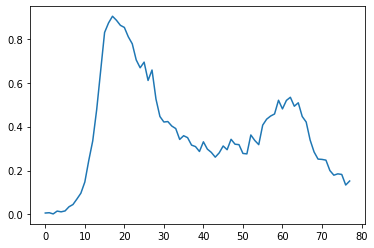

In [7]:
plt.plot(Xs_3d[:,10,0])

In [8]:
t_s = time.time()

Xs_train_3d = []
Ys_train_3d = []
Xt_valid_3d = []
Xt_train_3d = []
Yt_valid_3d = []
Yt_train_3d = []

for i in range(Xs_3d.shape[2]):
    print('Starting det %i'%i)
    bda = BDA(kernel_type='linear', dim=seq_len-reduced_dim, lamb=lamb, mu=MU, gamma=1, T=2)  # T is iteration time
    Xs_new, Xt_new, A = bda.fit(
        Xs_3d[:, :, i], bda_utils.get_class(Ys_3d[:, :, i]), Xt_3d[:, :, i], bda_utils.get_class(Yt_3d[:, :, i])
    )  # input shape: ns, n_feature | ns, n_label_feature
    
    # normalize
    Xs_new, Xs_new_min, Xs_new_max = bda_utils.normalize2D(Xs_new)
    Xt_new, Xt_new_min, Xt_new_max = bda_utils.normalize2D(Xt_new)
    
    print(Xs_new.shape)
    print(Xt_new.shape)

    day_train_t = 1
    Xs_train = Xs_new.copy()
    Ys_train = Ys_3d[:, :, i]
    Xt_valid = Xt_new.copy()[int(96*day_train_t):, :]
    Xt_train = Xt_new.copy()[:int(96*day_train_t), :]
    Yt_valid = Yt_3d[:, :, i].copy()[int(96*day_train_t):, :]
    Yt_train = Yt_3d[:, :, i].copy()[:int(96*day_train_t), :]
    

print('Time spent:%.5f'%(time.time()-t_s))


Starting det 0
	Starting iter 0
1008.547619047619
	Starting iter 1
778.0194805194806
(78, 8)
(462, 8)
Time spent:1.10082


In [9]:
print(Xs_train.shape)
print(Ys_train.shape)
print(Xt_valid.shape)
print(Xt_train.shape)
print(Yt_valid.shape)
print(Yt_train.shape)

(78, 8)
(78, 1)
(366, 8)
(96, 8)
(366, 1)
(96, 1)


In [10]:
train_x = np.vstack([Xs_train, Xt_train])
train_y = np.vstack([Ys_train, Yt_train])

# LSTM

In [27]:
model = keras.models.Sequential()
# out shape: [window_size, hid_dim]
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LSTM(units=hid_dim, return_sequences=True))
model.add(keras.layers.LSTM(units=hid_dim, return_sequences=True))
model.add(keras.layers.LSTM(units=hid_dim, return_sequences=False))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1, activation='relu'))

bda_utils.setup_seed(1)

# Training on target data

In [28]:

model.compile(loss='mse', optimizer='adam')
history = model.fit(
    train_x[:, :, np.newaxis], train_y[:, :, np.newaxis],
    epochs=350, batch_size=64, validation_data=(Xt_valid[:, :, np.newaxis], Yt_valid[:, :, np.newaxis]),
    verbose=2, shuffle=True
)


Epoch 1/350
3/3 - 4s - loss: 0.2044 - val_loss: 0.2789
Epoch 2/350
3/3 - 0s - loss: 0.1950 - val_loss: 0.2659
Epoch 3/350
3/3 - 0s - loss: 0.1859 - val_loss: 0.2536
Epoch 4/350
3/3 - 0s - loss: 0.1792 - val_loss: 0.2419
Epoch 5/350
3/3 - 0s - loss: 0.1745 - val_loss: 0.2308
Epoch 6/350
3/3 - 0s - loss: 0.1706 - val_loss: 0.2209
Epoch 7/350
3/3 - 0s - loss: 0.1674 - val_loss: 0.2111
Epoch 8/350
3/3 - 0s - loss: 0.1643 - val_loss: 0.2023
Epoch 9/350
3/3 - 0s - loss: 0.1635 - val_loss: 0.1939
Epoch 10/350
3/3 - 0s - loss: 0.1587 - val_loss: 0.1863
Epoch 11/350
3/3 - 0s - loss: 0.1580 - val_loss: 0.1790
Epoch 12/350
3/3 - 0s - loss: 0.1547 - val_loss: 0.1715
Epoch 13/350
3/3 - 0s - loss: 0.1520 - val_loss: 0.1641
Epoch 14/350
3/3 - 0s - loss: 0.1502 - val_loss: 0.1562
Epoch 15/350
3/3 - 0s - loss: 0.1490 - val_loss: 0.1483
Epoch 16/350
3/3 - 0s - loss: 0.1474 - val_loss: 0.1407
Epoch 17/350
3/3 - 0s - loss: 0.1467 - val_loss: 0.1334
Epoch 18/350
3/3 - 0s - loss: 0.1438 - val_loss: 0.1258
E

Epoch 147/350
3/3 - 0s - loss: 0.0210 - val_loss: 0.1685
Epoch 148/350
3/3 - 0s - loss: 0.0179 - val_loss: 0.1707
Epoch 149/350
3/3 - 0s - loss: 0.0167 - val_loss: 0.1610
Epoch 150/350
3/3 - 0s - loss: 0.0169 - val_loss: 0.1686
Epoch 151/350
3/3 - 0s - loss: 0.0169 - val_loss: 0.1831
Epoch 152/350
3/3 - 0s - loss: 0.0172 - val_loss: 0.1878
Epoch 153/350
3/3 - 0s - loss: 0.0168 - val_loss: 0.1969
Epoch 154/350
3/3 - 0s - loss: 0.0165 - val_loss: 0.2052
Epoch 155/350
3/3 - 0s - loss: 0.0179 - val_loss: 0.2041
Epoch 156/350
3/3 - 0s - loss: 0.0172 - val_loss: 0.1998
Epoch 157/350
3/3 - 0s - loss: 0.0175 - val_loss: 0.2239
Epoch 158/350
3/3 - 0s - loss: 0.0167 - val_loss: 0.2328
Epoch 159/350
3/3 - 0s - loss: 0.0163 - val_loss: 0.2268
Epoch 160/350
3/3 - 0s - loss: 0.0176 - val_loss: 0.2282
Epoch 161/350
3/3 - 0s - loss: 0.0169 - val_loss: 0.2371
Epoch 162/350
3/3 - 0s - loss: 0.0167 - val_loss: 0.2398
Epoch 163/350
3/3 - 0s - loss: 0.0176 - val_loss: 0.2427
Epoch 164/350
3/3 - 0s - loss: 

Epoch 291/350
3/3 - 0s - loss: 0.0160 - val_loss: 0.0595
Epoch 292/350
3/3 - 0s - loss: 0.0166 - val_loss: 0.0456
Epoch 293/350
3/3 - 0s - loss: 0.0154 - val_loss: 0.0525
Epoch 294/350
3/3 - 0s - loss: 0.0169 - val_loss: 0.0794
Epoch 295/350
3/3 - 0s - loss: 0.0159 - val_loss: 0.0584
Epoch 296/350
3/3 - 0s - loss: 0.0161 - val_loss: 0.0480
Epoch 297/350
3/3 - 0s - loss: 0.0158 - val_loss: 0.0841
Epoch 298/350
3/3 - 0s - loss: 0.0159 - val_loss: 0.0737
Epoch 299/350
3/3 - 0s - loss: 0.0164 - val_loss: 0.0450
Epoch 300/350
3/3 - 0s - loss: 0.0163 - val_loss: 0.0389
Epoch 301/350
3/3 - 0s - loss: 0.0154 - val_loss: 0.0630
Epoch 302/350
3/3 - 0s - loss: 0.0158 - val_loss: 0.0816
Epoch 303/350
3/3 - 0s - loss: 0.0158 - val_loss: 0.0566
Epoch 304/350
3/3 - 0s - loss: 0.0154 - val_loss: 0.0549
Epoch 305/350
3/3 - 0s - loss: 0.0153 - val_loss: 0.0491
Epoch 306/350
3/3 - 0s - loss: 0.0160 - val_loss: 0.0459
Epoch 307/350
3/3 - 0s - loss: 0.0153 - val_loss: 0.0507
Epoch 308/350
3/3 - 0s - loss: 

# Visualization

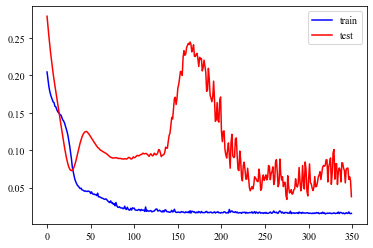

In [29]:
p1 = plt.plot(history.history['loss'], color='blue', label='train')
p2 = plt.plot(history.history['val_loss'], color='red',label='test')
plt.legend()

# Evaluation

In [30]:
g_t = Yt_valid.flatten()
pred = model.predict(Xt_valid[:, :, np.newaxis]).flatten()

Text(0, 0.5, 'Flow [veh/hr]')

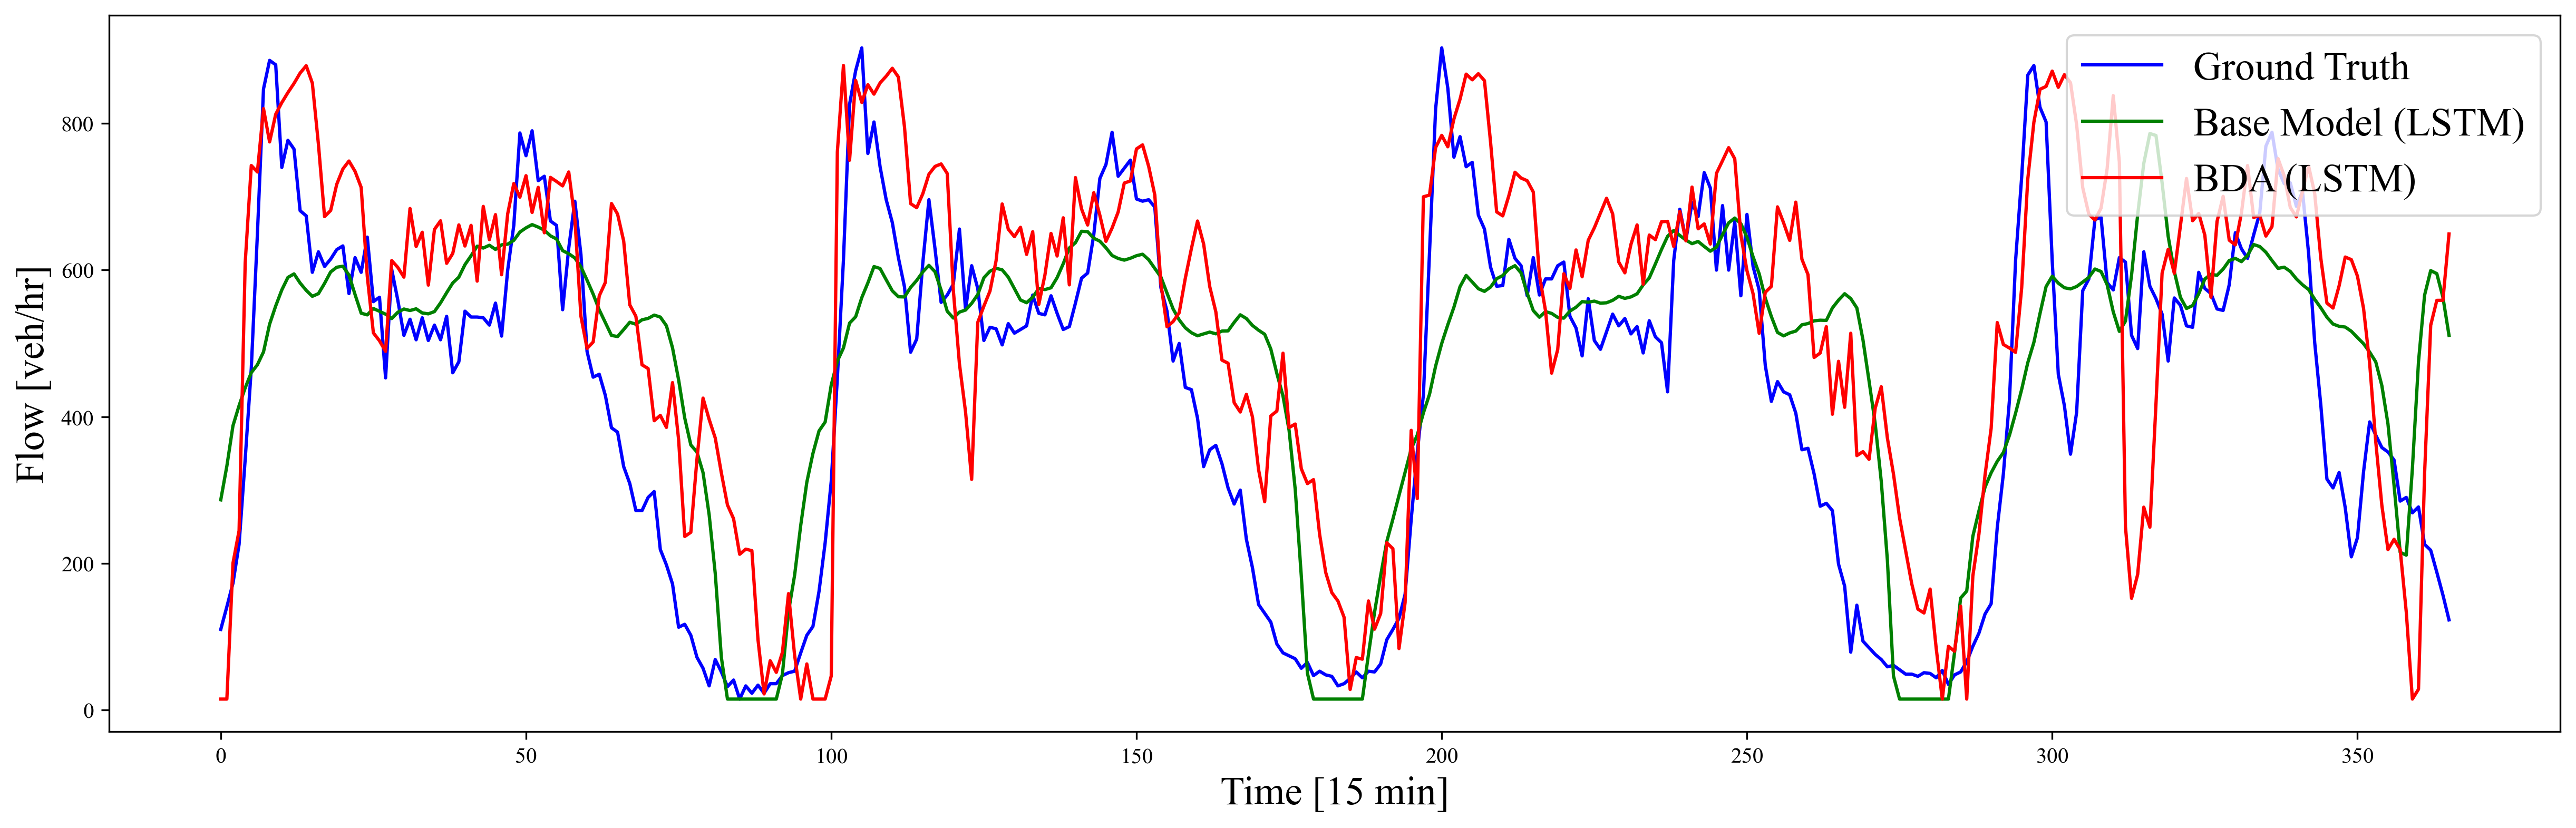

In [31]:
pred_base = pd.read_csv('./runs_base/base_data_plot/pred_base_LSTM.csv', header=None)
g_t_base = pd.read_csv('./runs_base/base_data_plot/g_t_base_LSTM.csv', header=None)

plt.rc('text', usetex=False)
plt.rcParams["font.family"] = "Times New Roman"

plt.figure(figsize=[20, 6], dpi=300)
diff = g_t_base.shape[0]-g_t.shape[0]
plt.plot(range(g_t.shape[0]), g_t_base[diff:]*(903-15)+15, 'b', label='Ground Truth')
plt.plot(range(g_t.shape[0]), pred_base[diff:]*(903-15)+15, 'g', label='Base Model (LSTM)')
# plt.figure()
# plt.plot(range(371), g_t_bda)
plt.plot(range(g_t.shape[0]), pred*(903-15)+15, 'r', label='BDA (LSTM)')
plt.legend(loc=1, fontsize=18)
plt.xlabel('Time [15 min]', fontsize=18)
plt.ylabel('Flow [veh/hr]', fontsize=18)

In [21]:
print(bda_utils.nrmse_loss_func(pred, g_t, 0))
print(bda_utils.smape_loss_func(pred, g_t, 0))
print(bda_utils.mae_loss_func(pred, g_t, 0))
print(bda_utils.mape_loss_func(pred, g_t, 0))

0.1681626189033309
0.43906857635307583
0.13474173405573825
1.206917218793393


/Users/kylezhang/Downloads/Github/BDA_traffic/bda_utils.py:76: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(eliminate_nan(np.fabs(labels[mask]-preds[mask])/labels[mask]))
